# Random Forest

## Imports and custom functions

First, we import libraries, arrays and list we are going to use for this section.

We also redefine a custom function `display_classification_reports_confusion_matrices()` used after GridSearch to display classification report and confusion matrix overall, but also by customer class to assess predictive power for each customer class. `custom_format()` is used to reformat grid_search results and improve readability.

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

In [2]:
def display_classification_reports_confusion_matrices(y_pred):
    """
    Takes predictions array as input and display classificaiton report overall and then
    Confusion matrices by customer class (rfm_label) that has been previously one hot encoded
    """
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    fig.subplots_adjust(wspace=0.8)

    # Plots standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    disp1 = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=class_names, ax=ax1)
    disp1.ax_.set_xticklabels(class_names, rotation=90)
    disp1.im_.colorbar.remove()

    # Plots normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    disp2 = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, normalize="true", display_labels=class_names, ax=ax2)
    disp2.ax_.set_xticklabels(class_names, rotation=90)
    disp2.im_.colorbar.remove()

    # Get classification report
    print(classification_report(y_test, y_pred, output_dict=False, zero_division=1))
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    # Get precision, recall, f1 from report dict
    precision = round(report['weighted avg']['precision'], 2)
    recall = round(report['weighted avg']['recall'], 2)
    f1 = round(report['weighted avg']['f1-score'], 2)
    
    # Format title
    title_formatted = f"Overall Confusion Matrices\nprecision={precision} recall={recall} f1={f1}"
    
    fig.suptitle(title_formatted, y=1.005)
    plt.show()
    
    # OHE columns matching our rfm_labels
    labels_of_interest = ['rfm_label_Good Customers', 'rfm_label_Low Value Customers', 'rfm_label_VIP']

    # Find column indices corresponding to OHE rfm_label columns
    label_indices = [np.where(columns == label)[0][0] for label in labels_of_interest]

    # Iterate over each OHE rfm_label
    for i, label in enumerate(labels_of_interest):    
        # Find column position of OHE rfm_label
        label_index = label_indices[i]

        # Find unique values in the column of interest and their maximum
        unique_values = np.unique(X_test[:, label_index])
        max_value = np.max(unique_values)

        # Find rows of X_test where OHE rfm_label is true
        rows_of_interest = np.where(X_test[:, label_index] == max_value)
        
        # Select corresponding rows of y_test and y_pred
        y_test_subset = y_test[rows_of_interest]
        y_pred_subset = y_pred[rows_of_interest]

        # Restrict our class_names to only classes in subset
        # VIP can only become 5 values, other 6.
        classes = np.unique(y_test_subset)
        class_names_subset = [class_names[label] for label in classes if label in class_labels]

        fig, axs = plt.subplots(1, 2, figsize=(9, 4))

        # Plots standard confusion matrix
        axs[0].set_title("Confusion Matrix (counts)")
        disp1 = ConfusionMatrixDisplay.from_predictions(
            y_test_subset, y_pred_subset, display_labels=class_names_subset, ax=axs[0])
        disp1.ax_.set_xticklabels(class_names_subset, rotation=90)
        disp1.im_.colorbar.remove()

        # Plots normalized confusion matrix
        axs[1].set_title("Confusion Matrix (ratios)")
        disp2 = ConfusionMatrixDisplay.from_predictions(
            y_test_subset, y_pred_subset, normalize="true", display_labels=class_names_subset, ax=axs[1])
        disp2.ax_.set_xticklabels(class_names_subset, rotation=90)
        disp2.im_.colorbar.remove()

        # Get classification report
        report = classification_report(y_test_subset, y_pred_subset, output_dict=True, zero_division=1)
        # Get precision, recall, f1 from report dict
        precision = round(report['weighted avg']['precision'], 2)
        recall = round(report['weighted avg']['recall'], 2)
        f1 = round(report['weighted avg']['f1-score'], 2)
        # Format title
        title_formatted = f"{label}\nprecision={precision} recall={recall} f1={f1}"
        
        # Set figure title to label of interest
        fig.subplots_adjust(wspace=0.8)
        fig.suptitle(title_formatted, y=1.005)
        plt.show()

In [3]:
# Custom formatting for cv_results
pd.options.display.max_columns = None

def custom_format(value, col_name):
    if col_name.startswith('param_'):
        return value
    elif 'time' in col_name:
        return round(value, 0)
    elif 'mean' in col_name:
        return round(value, 3)
    elif 'std' in col_name:
        return round(value, 4)
    else:
        return value

Now, we load train and test set and also outliers arrays that can be used in outlier removal.

In [4]:
class_labels = [0, 1, 2, 3, 4]
class_names = ['Sleeping Dog', 'Low Value Customers', 'Sleeping Beauty', 'Good Customers', 'VIP']
colors = ['red', 'orange', 'purple', 'blue', 'green']

# Load test set from pickle file
with open('testset.pkl', 'rb') as f:
    testset = pickle.load(f)
X_test, y_test = testset['X_test'], testset['y_test']

# Load train set from pickle file
with open('trainset_base.pkl', 'rb') as f:
    trainset = pickle.load(f)
X_train, y_train = trainset['X_train'], trainset['y_train']

with open('columns.pkl', 'rb') as f:
    columns = pickle.load(f)
    
# Load dictionary containing all outliers array
with open("outliers.pkl", "rb") as f:
    loaded_outliers_dict = pickle.load(f)

In [5]:
X_train_outliers_conservative = loaded_outliers_dict["conservative"]
X_train_outliers_aggressive = loaded_outliers_dict["aggressive"]
X_train_outliers_lof = loaded_outliers_dict["lof"]
X_train_outliers_iforest = loaded_outliers_dict["iforest"]

outlier_dict = {
    "aggressive": X_train_outliers_aggressive,
}

In [6]:
X_train.shape

(63700, 83)

In [7]:
model_file_name = 'RandomForest.csv'

## Decision Tree with depth = 3

Here we look at accuracy we achieve using a simple decision tree with depth equals to 3 and we visualize it on a tree figure.

In [8]:
decision_tree = DecisionTreeClassifier(max_depth=3)

decision_tree.fit(X_train, y_train)

accuracy = decision_tree.score(X_train, y_train)
accuracy_test = decision_tree.score(X_test, y_test)

print("Accuracy of decision tree with depth=3: {:.2f}%".format(accuracy * 100))
print("Accuracy on unseen test data: {:.2f}%".format(accuracy_test * 100))

Accuracy of decision tree with depth=3: 44.42%
Accuracy on unseen test data: 44.56%


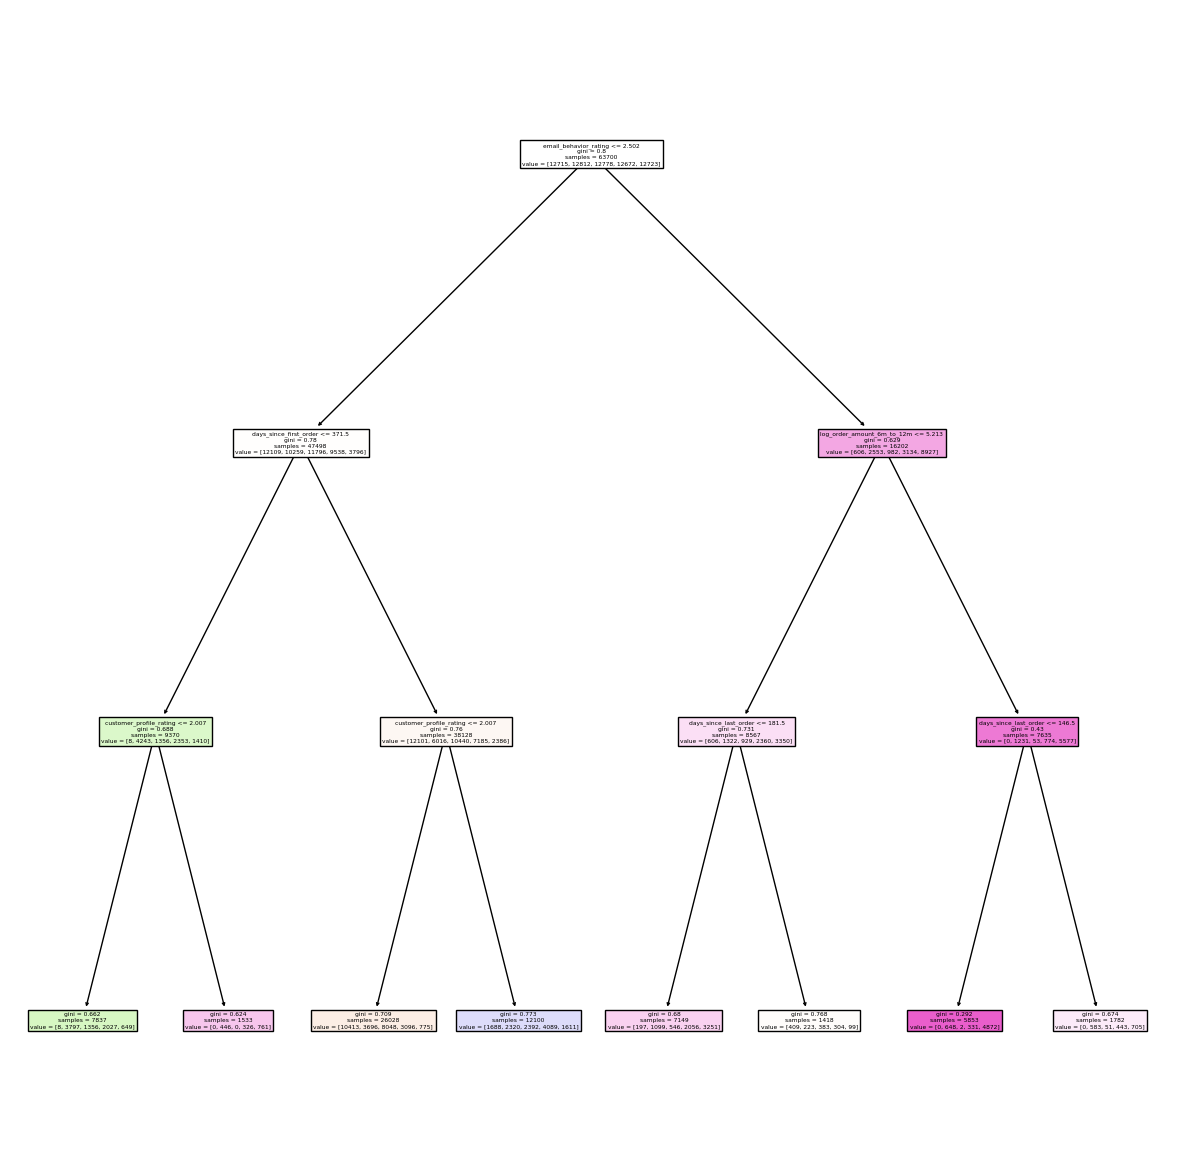

In [9]:
plt.figure(figsize=(15, 15))
plot_tree(decision_tree, filled=True, feature_names=columns)
plt.show()

## Random forest

Here is our machine learning plan from proposal

## Plan

Model interpretability, suitability, scalability, diversity, …?
- __Interpretability__: Random Forest is relatively easy to interpret compared to deep learning models, as it is an ensemble of decision trees. Each decision tree can be visualized and we will start with a Decision Tree with depth of three to visualize which variables create first branches. Additionally, feature importances can be extracted, which we will consider as an iterative step in our process to remove some variables from our dataset and increase training speed of our models (if we don't dramatically decrease weighted f1 of course). Random Forest is prone to overfitting, but less than decision trees of course, as it is an average of decision trees.
- __Scalability__: From what we have seen, Random Forest scales relatively well, but one has to keep in mind to not test to many features combination. This part of the [course](https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v3/subjects/decision-trees-and-svms-v4/units/different-model-families-v2) is to keep in mind.
> If model is unconstrained in depth we get overfitting and the model predicts exactly the target values of samples in the training set. One can counteract such overfitting by fixing the pruning parameters like max_depth, min_samples_split, or min_samples_leaf. For random forests, the above points hold as well but the last point is mitigated by the averaging across multiple trees using different feature and sample spaces. In general, models that create their predictions by averaging or aggregating the target values of subsets of the training set, can not go beyond what they have been exposed to in training. Thus these models can only predict within the range of target values observed in training. Unlike linear models, they cannot extrapolate beyond the training data. This is the case for decision trees and random forests since the predictions are calculated from the mean target value for each leaf.
- __Diversity / Robustness__: The Random Forest model introduces diversity among the individual trees by using a random subset of features at each split and bootstrapped samples for training (with default setting bootstrap=true, [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). Random Forests are robust to outliers and noise in the data since the decision trees' averaging process reduces the impact of any single tree's errors. 

Methodologies to be used to train and finetune my models?

- We will use scikit-learn's GridSearchCV to find the best hyperparameters. The grid search involves an exhaustive search through a specified parameter grid and evaluates the model with cross-validation to find the best combination of hyperparameters. It will return both validation score and train score with return_train_score=True and this can be use to assess overfitting, as well as score on unseen test data. 

Model Parameters
- __max_depth__ is the maximum depth of each tree in the Random Forest. It determines the maximum number of nodes from the root to the farthest leaf.
- __n_estimators__ is the number of trees in the Random Forest. The more trees, the more robust the model becomes, but it can also increase training time.
- __criterion__ determines the impurity measure used to split nodes in the decision trees. We will use Gini impurity, which indicates the likelihood of new, random data being misclassified if it were given a random class label according to the class distribution in the dataset [source](https://www.learndatasci.com/glossary/gini-impurity/). We will try other parameters like entropy, but will end up using Gini if it perfoms similarly as it is more straighforward.
- __min_samples_split__ or __min_samples_leaf__ . Here point from course stands and we will have to investigate the tradeoff between overfitting and test accuracy. These parameters should help fight overfitting, the question of what would be tradeoff with accuracy on validation.

## Adaptations based on observations after running model

We simplify the following as we have seen better perfomance
- __Criterion__ : gini 
- __PCA__ : we have seen better perfomance without using PCA in pipeline
- __max_depth__: I chose a range of lower values like 5 to 15, with a step of 3, because we want to explore different levels of tree complexity. We will fine tune and explore by a step of 1 max_depth parameter in a later section
- **n_estimators**: here we go with high number of trees to limit overfitting
- **min_samples_split** / **min_samples_leaf**: Adjusting these did not have an obvious impact on overfitting so instead we went for max_features parameter below.
- **max_features**: This hyperparameter controls the number of features that are considered when looking for best split at each node. Limiting the number of features can help reduce overfitting by adding some randomness to the feature selection process. I tested multiple parameter like 30, 40, 50, sqrt (which sets max_features=sqrt(n_features)). I stick to 30 as it is where I've found best performance.

In [10]:
param_grid = {
    'preprocessor__scaler': [RobustScaler()],
    'classifier__max_depth': np.arange(5, 15, 3),
    'classifier__n_estimators': [300],
    'classifier__criterion': ['gini'],
    'classifier__max_features': [None, 30],
}


# Create pipeline
pipe = Pipeline([
    ('preprocessor', ColumnTransformer(transformers=[
        ('scaler', 'passthrough', list(range(X_train.shape[1]))),
    ])),
    ('classifier', RandomForestClassifier())
])

# Initialize cv_results
cv_results = pd.DataFrame()
best_score = 0
best_params = None
best_outlier_name = None

for outlier_name, outlier_mask in outlier_dict.items():
    print("Removing outliers based on", outlier_name)

    # Remove rows with outliers from X_train and y_train
    X_train_filtered = X_train[outlier_mask != 1]
    y_train_filtered = y_train[outlier_mask != 1]

    # Use GridSearch to find the best parameter
    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=3,
        n_jobs=6,
        verbose=1,
        return_train_score=True,
        scoring={
            'f1': make_scorer(f1_score, average='weighted'),
            'precision': make_scorer(precision_score, average='weighted'),
            'recall': make_scorer(recall_score, average='weighted')
        },
        refit='f1'  
    )

    # Start timer
    start_time = time.time()

    # Fit grid search on training data
    grid_search.fit(X_train_filtered, y_train_filtered)

    # End timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print time taken to fit the model
    print("Time taken to fit the model: {:.0f} seconds".format(elapsed_time))

    # Print best parameters found by GridSearchCV
    print("Best parameters found by GridSearchCV:", grid_search.best_params_)

    # Store the best parameters if the score is better than previous best
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_outlier_name = outlier_name
   
    # Evaluation on test data
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print("Accuracy on unseen test data: {:.2f}%".format(test_score * 100))
    
    # Append current cv_results to the overall cv_results dataframe
    current_cv_results = pd.DataFrame(grid_search.cv_results_)
    current_cv_results['param_outliers_removal'] = outlier_name
    cv_results = cv_results.append(current_cv_results, ignore_index=True)

# Reset index of the overall cv_results dataframe
cv_results.reset_index(drop=True, inplace=True)

# Filter X_train and y_train based on best outlier removal method found
best_outlier_mask = outlier_dict[best_outlier_name]
X_train_best = X_train[best_outlier_mask != 1]
y_train_best = y_train[best_outlier_mask != 1]

# Fit best model
pipe.set_params(**best_params)
pipe.fit(X_train_best, y_train_best)

# Evaluation on test data
test_score = pipe.score(X_test, y_test)
print("Accuracy on unseen test data: {:.2f}%".format(test_score * 100))

# Assign pipeline to best_model
best_model = pipe

Removing outliers based on aggressive
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Time taken to fit the model: 577 seconds
Best parameters found by GridSearchCV: {'classifier__criterion': 'gini', 'classifier__max_depth': 14, 'classifier__max_features': 30, 'classifier__n_estimators': 300, 'preprocessor__scaler': RobustScaler()}
Accuracy on unseen test data: 63.72%
Accuracy on unseen test data: 63.91%


In [11]:
cv_results = cv_results.sort_values("mean_test_f1", ascending=False)

file_path = os.path.join('gs_results', model_file_name)
cv_results.to_csv(file_path, index=False)

# Get columns starting with 'param_'
param_columns = [col for col in cv_results.columns if col.startswith('param_')]

# Create a list of desired column names
desired_columns = [
    'mean_fit_time',
    'mean_test_f1', 'mean_train_f1',
    *param_columns, 
    'std_test_f1', 'std_train_f1',
    'mean_test_precision', 'mean_train_precision',
    'std_test_precision', 'std_train_precision',
    'mean_test_recall', 'mean_train_recall',
    'std_test_recall', 'std_train_recall',    
]

# Apply custom formatting function and select columns
cv_results = cv_results.apply(lambda col: col.apply(lambda value: custom_format(value, col.name)))
cv_results = cv_results[desired_columns]
cv_results.head(20)

,mean_fit_time,mean_test_f1,mean_train_f1,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,param_preprocessor__scaler,param_outliers_removal,std_test_f1,std_train_f1,mean_test_precision,mean_train_precision,std_test_precision,std_train_precision,mean_test_recall,mean_train_recall,std_test_recall,std_train_recall
7,84.0,0.607,0.887,gini,14,30.0,300,RobustScaler(),aggressive,0.0040,0.0017,0.612,0.895,0.0046,0.0021,0.616,0.888,0.0042,0.0016
6,218.0,0.597,0.861,gini,14,NaN,300,RobustScaler(),aggressive,0.0053,0.0041,0.602,0.870,0.0065,0.0042,0.607,0.861,0.0054,0.0040
5,69.0,0.563,0.713,gini,11,30.0,300,RobustScaler(),aggressive,0.0020,0.0010,0.568,0.725,0.0031,0.0014,0.576,0.720,0.0027,0.0011
4,184.0,0.559,0.706,gini,11,NaN,300,RobustScaler(),aggressive,0.0025,0.0025,0.565,0.720,0.0044,0.0025,0.572,0.712,0.0035,0.0024
3,52.0,0.525,0.562,gini,8,30.0,300,RobustScaler(),aggressive,0.0023,0.0016,0.528,0.567,0.0026,0.0018,0.540,0.576,0.0025,0.0019
2,139.0,0.517,0.561,gini,8,NaN,300,RobustScaler(),aggressive,0.0023,0.0006,0.525,0.574,0.0036,0.0018,0.537,0.579,0.0021,0.0003
0,86.0,0.485,0.493,gini,5,NaN,300,RobustScaler(),aggressive,0.0023,0.0011,0.492,0.501,0.0032,0.0064,0.491,0.498,0.0013,0.0015
1,32.0,0.481,0.486,gini,5,30.0,300,RobustScaler(),aggressive,0.0008,0.0029,0.481,0.486,0.0025,0.0018,0.502,0.507,0.0031,0.0001


## Results

### Classification report and Confusion matrices

We use our custom function to display confusion matrix and classications reports. Note that we don't extensively comment results here as they are from best model on validation f1 weighted score and we might end up chosing a different model with a better trade off between validation f1 weighted score and overfitting. We will do this in our results notebook, where we compile results from all our models.

              precision    recall  f1-score   support

           0       0.65      0.91      0.76      7803
           1       0.62      0.55      0.58      7823
           2       0.59      0.42      0.49      7800
           3       0.56      0.58      0.57      7740
           4       0.77      0.73      0.75      7834

    accuracy                           0.64     39000
   macro avg       0.64      0.64      0.63     39000
weighted avg       0.64      0.64      0.63     39000



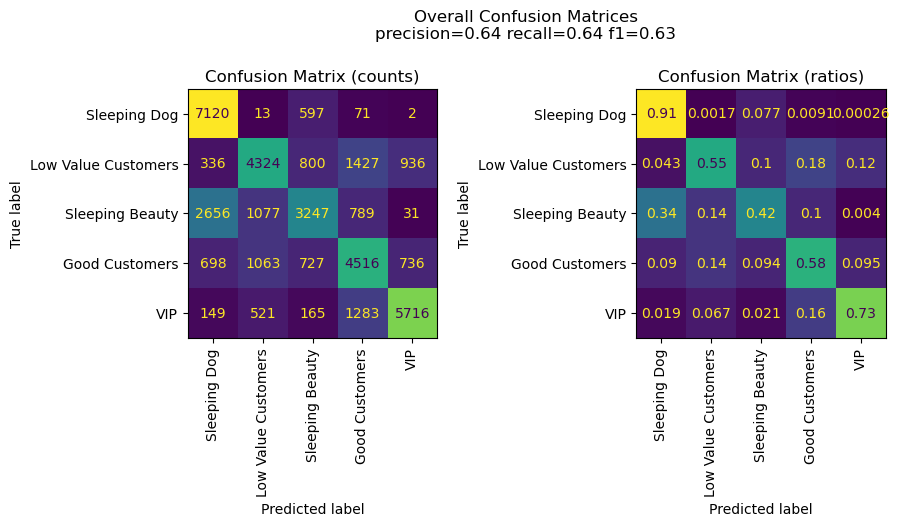

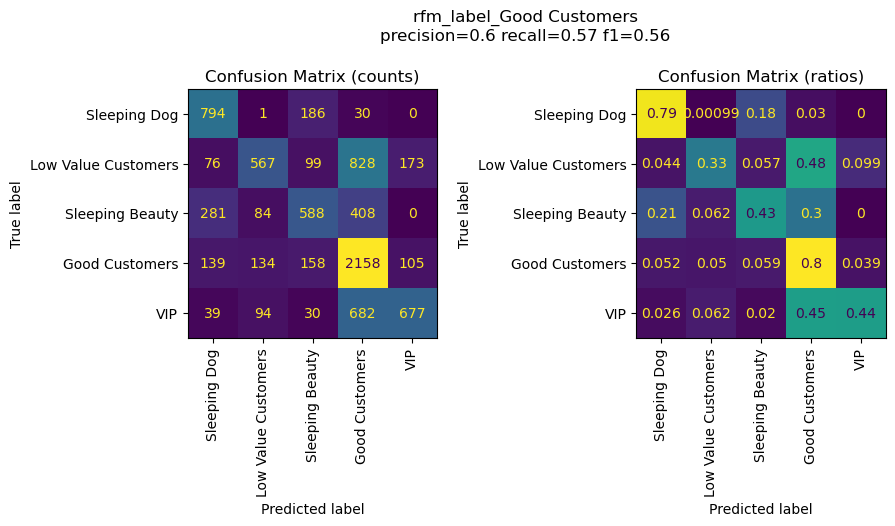

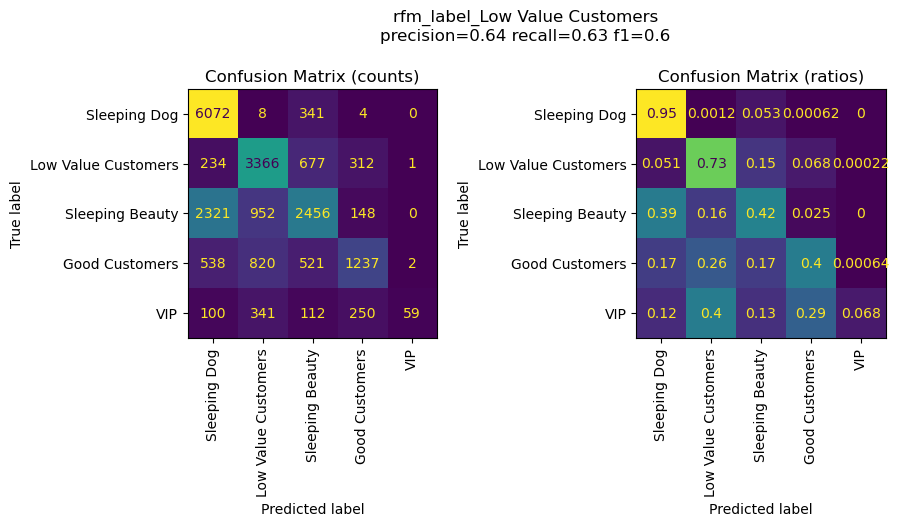

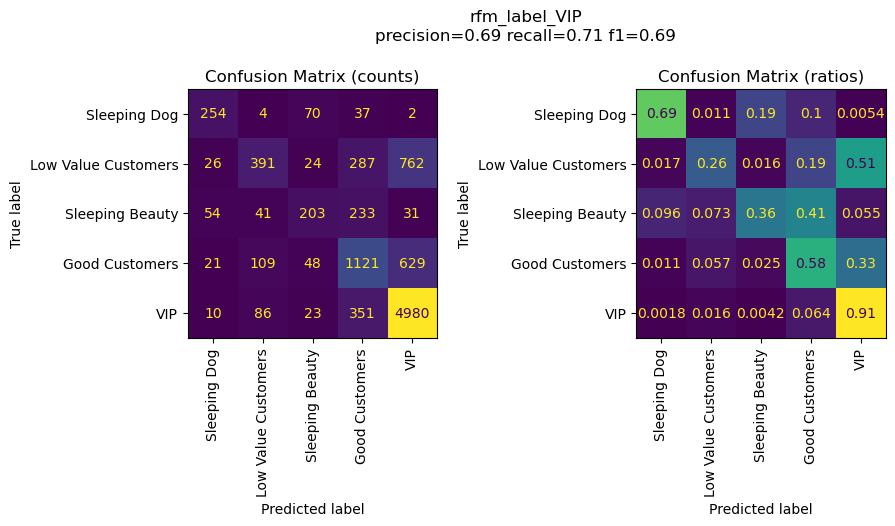

In [12]:
# Predict category of test dataset
y_pred = best_model.predict(X_test)
display_classification_reports_confusion_matrices(y_pred)

### Ranking features
The random forest estimator provides a ranking of the features according to their importance in the classification task via the feature_importances_ attribute. It is specific to random forest so we go ahead and save it as csv to inspect it, see if we can find ideas for further feature engineering.

In [13]:
# Get feature importance from random forest
importances = best_model.named_steps['classifier'].feature_importances_

# Convert importances to a pandas dataframe with column names
importances_df = pd.DataFrame(importances, index=range(len(importances)), columns=['Importance'])

# Set index of the dataframe to the column names
importances_df = importances_df.set_index(pd.Index(columns[:-1]))
importances_df.to_csv('rf_importances.csv')

## Looking for optimal value of max_depth

Based on grid_search results we have seen that
- Classifier perfoms similary with or without RobustScaler. We chose to apply RobustScaler to keep it similar to other models
- Outliers exclusion that shows best performance is the aggressive one, combining all outliers from zscore, lof and iforest.
- Limiting number of features to consider when looking for the best split proves valuable

We retrain using grid_search to search for optimal value of max_depth

In [14]:
# Remove rows with outliers from X_train and y_train
outlier_mask = X_train_outliers_aggressive
X_train_filtered = X_train[outlier_mask != 1]
y_train_filtered = y_train[outlier_mask != 1]

In [15]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
rf = RandomForestClassifier(
    criterion='gini',
    n_estimators=300,
    max_features=30
)

                                
param_grid = {
    'max_depth': np.arange(1, 40, 2),
}

grid = GridSearchCV(
    rf,
    param_grid=param_grid,
    n_jobs=6,
    verbose=1,
    return_train_score=True,
    scoring={
        'f1': make_scorer(f1_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
    },
    refit='f1'  
)

# Fit to training
grid.fit(X_train, y_train)

# Print best parameters and corresponding score for training
print("Best parameters: {}".format(grid.best_params_))
print("Training score: {:.2f}".format(grid.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'max_depth': 33}
Training score: 0.69


In [17]:
cv_results = pd.DataFrame(grid.cv_results_)

In [18]:
# Function to compute F1 weighted score for a given max_depth
def compute_f1_weighted_for_max_depth(max_depth, X_test, y_test):
    rf = RandomForestClassifier(
        criterion='gini',
        n_estimators=300,
        max_features=30,
        max_depth=max_depth
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return f1_score(y_test, y_pred, average='weighted')

In [19]:
# Rename cv_results["mean_test_f1"] to mean_valid_f1 and cv_results["std_test_f1"] to std_valid_f1
cv_results = cv_results.rename(columns={"mean_test_f1": "mean_valid_f1", "std_test_f1": "std_valid_f1"})

# Initialize the new 'mean_test_f1' column with NaN values
cv_results["mean_test_f1"] = np.nan

# Loop through the rows in cv_results and add the F1 weighted score for the test set
for index, row in cv_results.iterrows():
    max_depth = row['param_max_depth']
    
    # Update the 'mean_test_f1' column value for the current max_depth
    cv_results.at[index, 'mean_test_f1'] = compute_f1_weighted_for_max_depth(max_depth, X_test, y_test)

In [20]:
columns = [
    "mean_valid_f1",
    "std_valid_f1",
    "mean_test_f1",
    "mean_train_f1",
    "std_train_f1",
    "param_max_depth",
]

cv_results = cv_results[columns].sort_values("mean_test_f1", ascending=False)
cv_results.head(25)

,mean_valid_f1,std_valid_f1,mean_test_f1,mean_train_f1,std_train_f1,param_max_depth
16,0.693305,0.005165,0.725426,1.000000,0.000000,33
18,0.692751,0.005311,0.724982,1.000000,0.000000,37
17,0.691811,0.006426,0.724659,1.000000,0.000000,35
14,0.689470,0.006020,0.723819,0.999996,0.000008,29
13,0.689910,0.005321,0.722946,0.999980,0.000021,27
19,0.691610,0.004643,0.722762,1.000000,0.000000,39
15,0.690581,0.005394,0.721880,1.000000,0.000000,31
12,0.688827,0.004587,0.721379,0.999808,0.000085,25
11,0.684021,0.005705,0.714576,0.998714,0.000154,23
10,0.679280,0.006108,0.709347,0.995127,0.000459,21


## Plot the training and validation curves

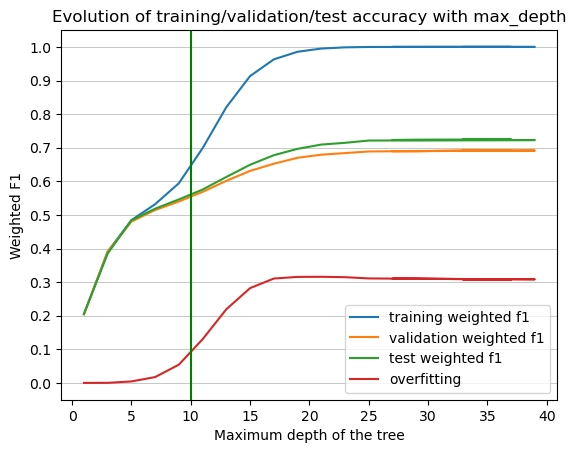

In [21]:
import matplotlib.ticker as ticker

# Calculate the overfitting
overfitting = cv_results["mean_train_f1"] - cv_results["mean_valid_f1"]

# Plot training/validation/test accuracy curves
fig, ax = plt.subplots()
ax.plot(cv_results["param_max_depth"], cv_results["mean_train_f1"], label='training weighted f1')
ax.plot(cv_results["param_max_depth"], cv_results["mean_valid_f1"],  label='validation weighted f1')
ax.plot(cv_results["param_max_depth"], cv_results["mean_test_f1"],  label='test weighted f1')

# Add the overfitting line
ax.plot(cv_results["param_max_depth"], overfitting, label='overfitting')

# Add horizontal gridlines with an increment of 0.1
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.grid(axis='y', linewidth=0.5)

ax.set_xlabel('Maximum depth of the tree')
ax.set_ylabel('Weighted F1')
ax.axvline(10, c='g')

ax.set_title("Evolution of training/validation/test accuracy with max_depth")
ax.legend()
plt.show()

We chose maxdepth = 10 as a good tradeoff between f1 weighted score on validation and overfitting (difference of 10% of f1 weighted score between validation and train)

We observe that our validation and test scores were very close to each other. We believe that this is because our validation data was generated using cross-validation techniques applied to our training data, and our test data was extracted using the `train_test_split` function on the same dataset. This means that our test data was essentially drawn from the same time range and customer data as our training data, and was not drastically different from it.

Our primary motivation for prioritizing a lower f1 score and reduced overfitting is that customer behavior can be highly variable and subject to change over time. By limiting overfitting and prioritizing a more generalizable model, we can ensure that our model is better equipped to handle changes in customer behavior and make accurate predictions over time. We are not studying a natural behavior following physics law but rather something than can be eratic at times.

In the other models, we will not be displaying test weighted f1 but only validation weighted f1 as they are very close.